# Data Preparation

To start with, we'll present some data preparation. We've downloaded the GraphQL from Meetups.com for this event and we can start loading this and transforming the data for our purposes.

In [1]:
%pip install -q duckdb pandas pyarrow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import logging
import codecs
import json
from datetime import datetime

# import logging properly.
logging.basicConfig(format='%(asctime)s:%(name)-35s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S %z')
logging.getLogger("OAuthUtil").setLevel(logging.WARNING)
logger = logging.getLogger(__name__)

is_debug = logging.getLogger().getEffectiveLevel() == logging.DEBUG

meetups = []


for input in Path("../resources/meetups/aicamp").glob("*.json"):
    logger.info(f"Found file [{input.name}]")

    with codecs.open(input, encoding="utf-8") as f:
        content = json.loads(f.read())

    edges = content['data']['groupByUrlname']['events']['edges']
    for edge in edges:
        event = edge['node']
        title = event['title']
        event_datetime = datetime.strptime(event['dateTime'], "%Y-%m-%dT%H:%M:%S%z")
        event_date_str = datetime.strftime(event_datetime, '%Y/%m/%d')
        num_going = event['going']['totalCount']

        description_lines = event['description'].split("\n")

        skip_contents = [
            "Pre-registration is required, please complete RSVP here:",
            "https://www.aicamp.ai/event/eventdetails",
            "Welcome to our monthly in-person AI meetup in Sydney."
        ]
        
        content_lines = []

        for idx, line in enumerate(description_lines):
            skip = False
            for skip_content in skip_contents:
                if skip_content in line:
                    skip = True
                    break
            if skip:
                continue

            content_lines.append(line)
        description = "\n".join(content_lines)

        if is_debug:
            logger.debug(f"Description is:\n{description}")
        
                
        meetup = {
            "id": event['id'],
            "title": title,
            "description": description,
            "event_date": event_date_str,
            "event_year": datetime.strftime(event_datetime, '%Y'),
            "event_month": datetime.strftime(event_datetime, '%m'),
            "url": event['eventUrl'],
            "event_type": event['eventType'].lower(),
            "is_online": event['isOnline'],
            "num_going": num_going 
        }
        meetups.append(meetup)

    
logger.info(f"Total meetups is {len(meetups)}")
    

13:20:43 +1000:__main__                            INFO:Found file [gql2_01.json]
13:20:43 +1000:__main__                            INFO:Found file [gql2_02.json]
13:20:43 +1000:__main__                            INFO:Found file [gql2_03.json]
13:20:43 +1000:__main__                            INFO:Found file [gql2_04.json]
13:20:43 +1000:__main__                            INFO:Found file [gql2_05.json]
13:20:43 +1000:__main__                            INFO:Found file [gql2_06.json]
13:20:43 +1000:__main__                            INFO:Found file [gql2_07.json]
13:20:43 +1000:__main__                            INFO:Found file [gql2_08.json]
13:20:43 +1000:__main__                            INFO:Found file [gql2_09.json]
13:20:43 +1000:__main__                            INFO:Found file [gql2_10.json]
13:20:43 +1000:__main__                            INFO:Found file [gql2_11.json]
13:20:43 +1000:__main__                            INFO:Found file [gql2_12.json]
13:20:43 +1000:_

## View the Data

In [3]:
import pandas as pd
import duckdb
import pyarrow as pa

columns = []
for key in meetups[0].keys():
    columns.append(key)
    
df = pd.DataFrame(meetups, columns=columns)
con = duckdb.connect()
meetups_raw = pa.Table.from_pandas(df)

<Axes: xlabel='event_year_month'>

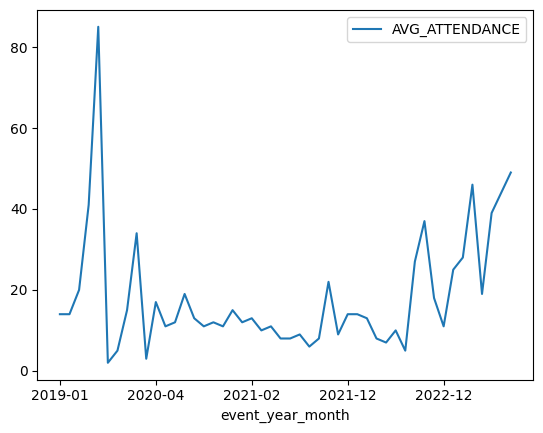

In [4]:
result_df = con.execute("""SELECT event_year || '-' || event_month as event_year_month, cast(round(avg(num_going),0) as int) AS AVG_ATTENDANCE
FROM meetups_raw
GROUP BY event_year, event_month
ORDER BY event_year, event_month""").fetchdf()

#%matplotlib inline
result_df.plot(x="event_year_month")

<Axes: xlabel='event_month'>

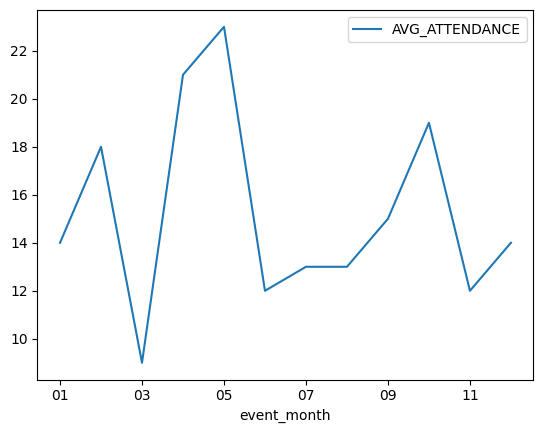

In [5]:
month_df = con.execute("""SELECT event_month, cast(round(avg(num_going),0) as int) AS AVG_ATTENDANCE
FROM meetups_raw
GROUP BY event_month
ORDER BY event_month""").fetchdf()

month_df.plot(x="event_month")

In [6]:
output_dir = "../output"
Path(output_dir).mkdir(parents=True, exist_ok=True)
con.execute(f"""COPY
    (SELECT * FROM meetups_raw)
    TO '{output_dir}/meetups_raw.parquet'
    (FORMAT 'parquet');""")